In [1]:
import os
import json
import pandas as pd
from urllib.parse import urlparse

# Specify the file paths
app_adid_file_path = "/content/drive/MyDrive/GAME_EDUCATIONAL/APP_ADID.txt"
failed_apps_file_path = "/content/drive/MyDrive/GAME_EDUCATIONAL/app_fail.txt"
har_files_folder = "/content/drive/MyDrive/GAME_EDUCATIONAL"

# Initialize an empty dictionary
app_adid_dict = {}

# Open and read the APP_ADID.txt file
with open(app_adid_file_path, 'r') as file:
    for line in file:
        # Split the line into domain and adid
        domain, adid = line.strip().split(': ')
        # Add to the dictionary
        app_adid_dict[domain] = adid

# Print the resulting dictionary
print("App adid:", app_adid_dict)

# Initialize an empty list
failed_apps = []

# Open and read the app_fail.txt file
with open(failed_apps_file_path, 'r') as file:
    for line in file:
        failed_apps.append(line.strip())

# Print the resulting list
print("Failed apps:", failed_apps)

App adid: {'com.ahaworld.ahaworld': 'eed1dd39-619c-4ab3-8f2f-eb6eeae31aeb', 'com.ailiyong.world.course': 'aa0341b4-020c-4f2e-b4d4-30d993a68558', 'com.bonbongame.toys.games.kids': 'd88cc69e-0ced-4d27-8d45-ae3b50b4488a', 'com.bt42.dianacleanup': '8dfe03cf-660b-4b46-ab91-ce7e1239459a', 'com.iz.my.doctor.hospital.kids.world.life.town.pretend.play.games': 'b598dc47-d287-4495-adf8-135d96609ec2', 'com.iz.tizi.royal.princess.dollhouse.life.games.home.design.world.my.wonder.town': '74f4a53b-2d36-4c71-9560-11376a392d5c', 'com.libii.frozenworld': 'a8ef5c2e-c204-4e09-ac07-45ff6803a73d', 'com.orange.coloring.learn.kids': '62bfef13-aa57-4ba2-9376-63638ccd53ee', 'com.pazugames.avatarmaker': '26563680-3778-4ba7-b12a-57e2f27a64cf', 'com.pepiplay.pepihome': '6698b46f-55b1-40ae-bc9f-b6bf35e6a997', 'com.PepiPlay.PepiHospital': '402d6644-bd92-468c-a7d3-ccb5b9919c9d', 'com.pepiplay.pepihospital2': '3316879d-db05-4791-bd15-d503a7f4290e', 'com.peppapig.worldofpeppapig_g': 'caa4856c-7843-498b-8e31-f539f8b572f0

In [2]:


# Function to check if ADID appears in the HAR file content
def check_adid_in_har(har_data, adid):
    return json.dumps(har_data).find(adid) != -1

def find_adid_in_har(data, adid, path=[]):
    if isinstance(data, dict):
        for key, value in data.items():
            new_path = path + [key]
            if isinstance(value, (dict, list)):
                result = find_adid_in_har(value, adid, new_path)
                if result:
                    return result
            elif isinstance(value, str) and adid in value:
                return new_path, value, value.index(adid)
    elif isinstance(data, list):
        for index, item in enumerate(data):
            new_path = path + [index]
            result = find_adid_in_har(item, adid, new_path)
            if result:
                return result
    return None

def get_substring_around_adid(value, adid_index, adid_length, context=10):
    start = max(0, adid_index - context)
    end = min(len(value), adid_index + adid_length + context)
    return value[start:end]


In [3]:
# Function to extract domains from HAR entries
def extract_domains_from_entries(entries):
    """
    Extract domains from HAR entries.
    """
    domains = []
    for entry in entries:
        url = entry.get('request', {}).get('url', '')
        if url:
            parsed_url = urlparse(url)
            domains.append(parsed_url.netloc)
    return domains

# Initialize a list to store domain results and a summary dictionary
domain_results = []
condition_summary = {
    '_ADID_2': {'total': 0, 'unique': 0},
    '_NO_ADID_QUIT': {'total': 0, 'unique': 0},
    '_ADID_GPC': {'total': 0, 'unique': 0}
}

# Sets to store unique domains per condition
unique_domains_adid_2 = set()
unique_domains_adid_gpc = set()
unique_domains_no_adid_quit = set()

# Iterate through all .har files in the folder
for app, adid in app_adid_dict.items():
    if not app in failed_apps:
        app_adid_2_path = os.path.join(har_files_folder, f"{app}_ADID_2.har")
        app_adid_gpc_path = os.path.join(har_files_folder, f"{app}_ADID_GPC.har")
        app_no_adid_quit_path = os.path.join(har_files_folder, f"{app}_NO_ADID_QUIT.har")
        process_files = [app_adid_2_path, app_adid_gpc_path, app_no_adid_quit_path]

        for file_path in process_files:
            if os.path.exists(file_path):
                # Open and read the .har file
                with open(file_path, 'r') as file:
                    data = json.load(file)

                # Determine the condition based on the filename
                if file_path.endswith('_ADID_2.har'):
                  # and not file_path.endswith('_NO_ADID.har')
                    condition = '_ADID_2'
                elif file_path.endswith('_NO_ADID_QUIT.har'):
                    condition = '_NO_ADID_QUIT'
                elif file_path.endswith('_ADID_GPC.har') and not file_path.endswith('_NO_ADID_GPC.har'):
                    condition = '_ADID_GPC'
                else:
                    condition = 'UNKNOWN'

                # Extract domains from HAR entries
                entries = data.get('log', {}).get('entries', [])
                domains = extract_domains_from_entries(entries)
                total_domains = len(domains)
                unique_domains = len(set(domains))

                # Add unique domains to the corresponding set
                if condition == '_ADID_2':
                    unique_domains_adid_2.update(domains)
                elif condition == '_ADID_GPC':
                    unique_domains_adid_gpc.update(domains)
                elif condition == '_NO_ADID_QUIT':
                    unique_domains_no_adid_quit.update(domains)

                # Check if the ADID is present in the HAR entries
                adid_found = False
                result = find_adid_in_har(entries, adid)
                if result:
                    path, value, adid_index = result
                    substring = get_substring_around_adid(value, adid_index, len(adid))
                    adid_found = True
                    print(f"ADID for {app} found in {file_path}")
                    print(f"  Path: {' -> '.join(map(str, path))}")
                    print(f"  Value: ...{substring}...")

                # Add results to domain_results
                domain_results.append({
                    "app_id": app,
                    "file": file_path,
                    "condition": condition,
                    "total_domains": total_domains,
                    "unique_domains": unique_domains,
                    "domains": domains,
                    "adid_found": adid_found
                })

                # Update condition summary
                if condition in condition_summary:
                    condition_summary[condition]['total'] += total_domains
                    condition_summary[condition]['unique'] += unique_domains

# Convert results to DataFrame
domain_df = pd.DataFrame(domain_results)

# Print DataFrame and condition summary
print(domain_df)
print("\nCondition Summary:")
for condition, counts in condition_summary.items():
    print(f"{condition}: Total Domains: {counts['total']}, Unique Domains: {counts['unique']}")

# Save to CSV
domain_df.to_csv('/content/drive/MyDrive/GAME_EDUCATIONAL/domain_results.csv', index=False)

# Save domain lists to individual files
for result in domain_results:
    domain_file = f"/content/drive/MyDrive/GAME_EDUCATIONAL/{result['app_id']}_domains.txt"
    with open(domain_file, 'w') as f:
        for domain in result['domains']:
            f.write(f"{domain}\n")


ADID for com.bt42.dianacleanup found in /content/drive/MyDrive/GAME_EDUCATIONAL/com.bt42.dianacleanup_ADID_2.har
  Path: 30 -> request -> postData -> text
  Value: .... *$8dfe03cf-660b-4b46-ab91-ce7e1239459a0 ¨ ò¡1...
ADID for com.PepiPlay.PepiHospital found in /content/drive/MyDrive/GAME_EDUCATIONAL/com.PepiPlay.PepiHospital_ADID_2.har
  Path: 107 -> request -> postData -> text
  Value: .... *$402d6644-bd92-468c-a7d3-ccb5b9919c9d0 ¨¡Çú¡1...
ADID for com.psv.lol.surprise.beauty_salon found in /content/drive/MyDrive/GAME_EDUCATIONAL/com.psv.lol.surprise.beauty_salon_NO_ADID_QUIT.har
  Path: 7 -> request -> postData -> text
  Value: .... *$a5fc37f9-22ac-4cba-ac69-e4fa484b61f90 ¨éÁ¡1...
ADID for com.sinyee.babybus.icecream found in /content/drive/MyDrive/GAME_EDUCATIONAL/com.sinyee.babybus.icecream_ADID_2.har
  Path: 2 -> request -> postData -> text
  Value: .... *$e5cece25-c1ba-4aff-9da2-03a2727df3b70 ¨Ó¡¡1...
ADID for com.tutotoons.app.powergirlsfantas

Total number of unique domains: 186
Top 10 domains:
googleads.g.doubleclick.net          594
pubads.g.doubleclick.net             427
cache-ssl.celtra.com                 378
csi.gstatic.com                      343
outcome-ssp.supersonicads.com        323
tracker.tutotoons.com                213
cdn.kidozplayer.com                  187
logs.ironsrc.mobi                    160
events.mz.unity3d.com                137
auction-load.unityads.unity3d.com    129
Name: count, dtype: int64


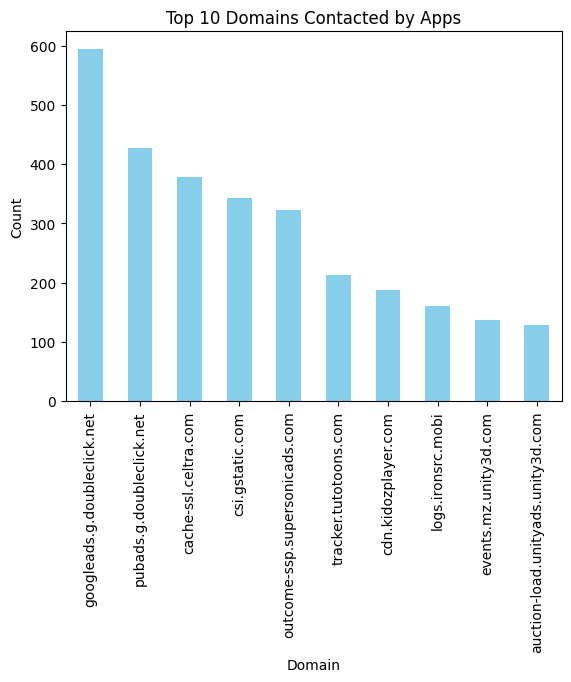

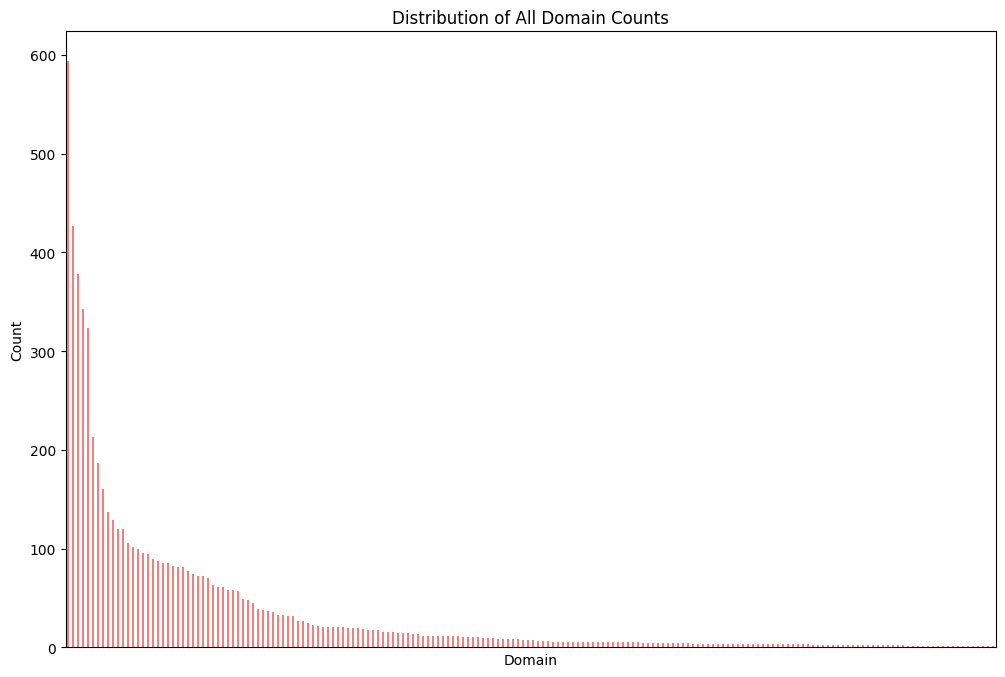

In [4]:
import matplotlib.pyplot as plt

# Load the domain analysis results from the CSV file
domain_df = pd.read_csv('/content/drive/MyDrive/GAME_EDUCATIONAL/domain_results.csv')

# Extract all domains
all_domains = domain_df['domains'].apply(eval).sum()

# Count occurrences of each domain
domain_counts = pd.Series(all_domains).value_counts()
# print(domain_counts)

# Calculate the total number of unique domains
total_unique_domains = domain_counts.index.nunique()
print(f"Total number of unique domains: {total_unique_domains}")

# Get the top 10 domains
top_10_domains = domain_counts.head(10)

print("Top 10 domains:")
print(top_10_domains)

# Plot the top 10 domains
top_10_domains.plot(kind='bar', color='skyblue')
plt.title('Top 10 Domains Contacted by Apps')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.show()


# Plot the distribution of all domain counts
plt.figure(figsize=(12, 8))
domain_counts.plot(kind='bar', color='lightcoral')
plt.title('Distribution of All Domain Counts')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks([])  # Hide x-axis labels
plt.show()

       condition  total_domains  unique_domains
0        _ADID_2      77.551724       24.448276
1      _ADID_GPC      69.758621       22.689655
2  _NO_ADID_QUIT      73.068966       23.103448


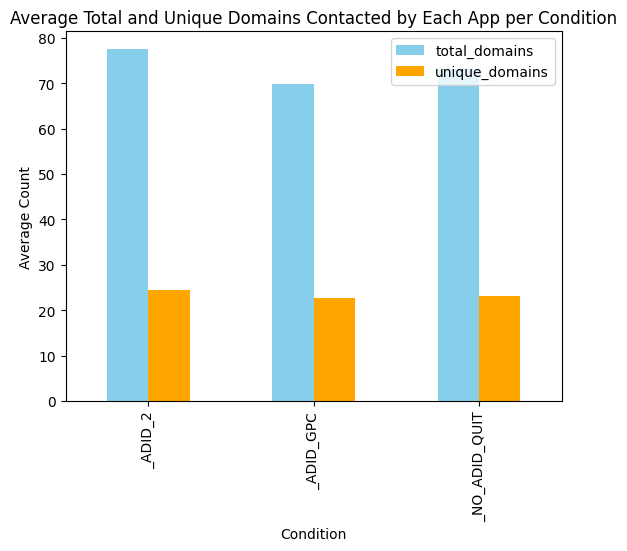

In [5]:
# Calculate average contact domains per app for each condition
average_domains_per_app = domain_df.groupby('condition').agg({
    'total_domains': 'mean',
    'unique_domains': 'mean'
}).reset_index()

print(average_domains_per_app)

average_domains_per_app.plot(kind='bar', x='condition', y=['total_domains', 'unique_domains'], color=['skyblue', 'orange'])
plt.title('Average Total and Unique Domains Contacted by Each App per Condition')
plt.xlabel('Condition')
plt.ylabel('Average Count')
plt.show()

condition                                           _ADID_2  _ADID_GPC  \
app_id                                                                   
com.PepiPlay.PepiHospital                               129        109   
com.ahaworld.ahaworld                                    50         29   
com.ailiyong.world.course                                23         14   
com.bonbongame.toys.games.kids                           68         52   
com.bt42.dianacleanup                                    40         25   
com.iz.my.doctor.hospital.kids.world.life.town....       29         27   
com.iz.tizi.royal.princess.dollhouse.life.games...       61         35   
com.libii.frozenworld                                    95         69   
com.orange.coloring.learn.kids                           15          2   
com.pepiplay.pepihome                                   105        105   
com.pepiplay.pepihospital2                              122        116   
com.peppapig.worldofpeppapig_g        

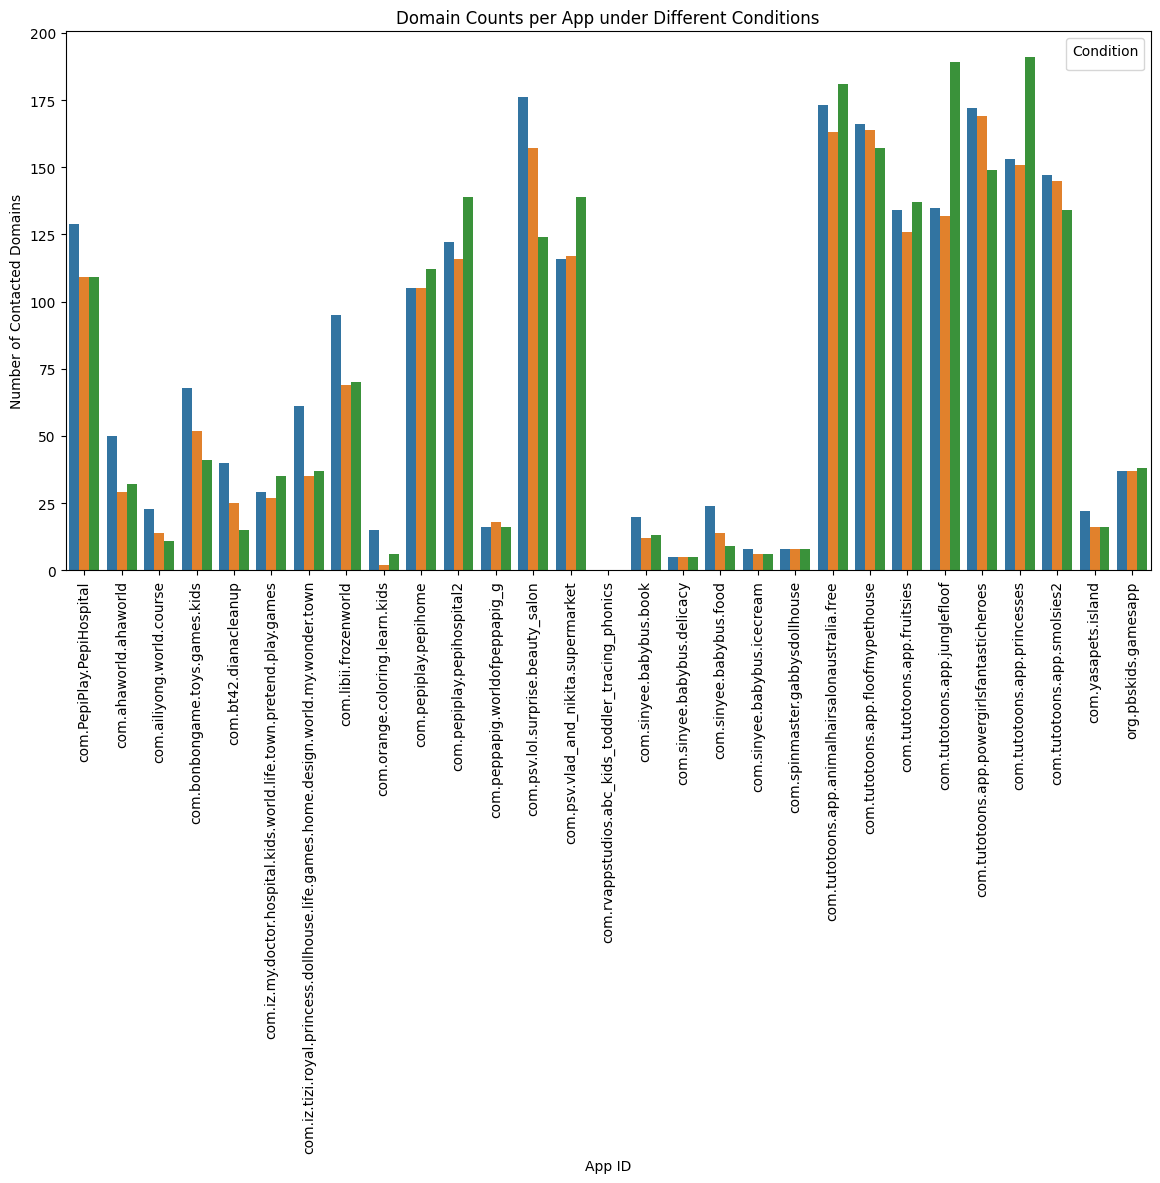

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the domain analysis results from the CSV file
domain_df = pd.read_csv('/content/drive/MyDrive/GAME_EDUCATIONAL/domain_results.csv')

# Group by app_id and condition, then count the number of domains for each app without removing duplicates
app_domain_counts = domain_df.groupby(['app_id', 'condition'])['domains'].apply(lambda x: sum(len(eval(domain)) for domain in x)).reset_index()

# Pivot the table to have conditions as columns and app_id as rows
app_domain_counts_pivot = app_domain_counts.pivot(index='app_id', columns='condition', values='domains').fillna(0)

# Print the table for reference
print(app_domain_counts_pivot)

# Melt the pivot table for easier plotting with seaborn
app_domain_counts_melted = app_domain_counts_pivot.reset_index().melt(id_vars='app_id', value_vars=['_ADID_2', '_ADID_GPC', '_NO_ADID_QUIT'], var_name='Condition', value_name='Domain Count')

# Plot a barplot to show the domain counts per app under each condition;
# keep all repeat domains
plt.figure(figsize=(14, 7))
sns.barplot(x='app_id', y='Domain Count', hue='Condition', data=app_domain_counts_melted)
plt.title('Domain Counts per App under Different Conditions')
plt.xlabel('App ID')
plt.ylabel('Number of Contacted Domains')
plt.xticks(rotation=90)
plt.legend(title='Condition')
plt.show()

condition                                           _ADID_2  _ADID_GPC  \
app_id                                                                   
com.PepiPlay.PepiHospital                                39         36   
com.ahaworld.ahaworld                                    18         13   
com.ailiyong.world.course                                13         13   
com.bonbongame.toys.games.kids                           24         13   
com.bt42.dianacleanup                                    12          6   
com.iz.my.doctor.hospital.kids.world.life.town....        5          5   
com.iz.tizi.royal.princess.dollhouse.life.games...        8          4   
com.libii.frozenworld                                    35         29   
com.orange.coloring.learn.kids                            5          1   
com.pepiplay.pepihome                                    38         38   
com.pepiplay.pepihospital2                               36         36   
com.peppapig.worldofpeppapig_g        

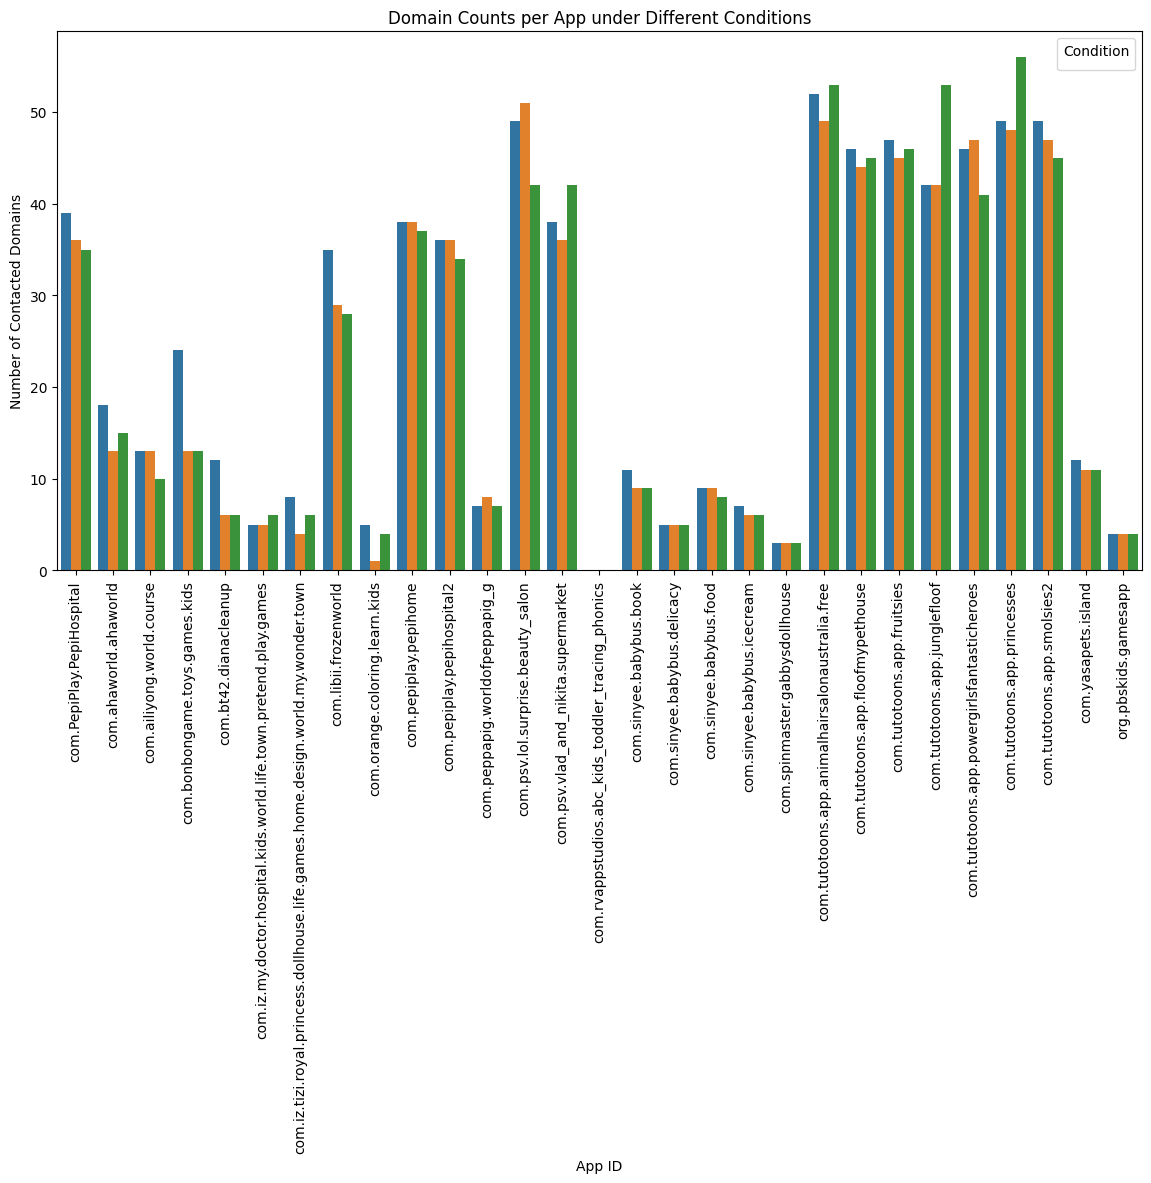

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the domain analysis results from the CSV file
domain_df = pd.read_csv('/content/drive/MyDrive/GAME_EDUCATIONAL/domain_results.csv')

# Group by app_id and condition, then count the number of domains for each app
app_domain_counts = domain_df.groupby(['app_id', 'condition'])['domains'].apply(lambda x: len(set(eval(''.join(x))))).reset_index()

# Pivot the table to have conditions as columns and app_id as rows
app_domain_counts_pivot = app_domain_counts.pivot(index='app_id', columns='condition', values='domains').fillna(0)

# Print the table for reference
print(app_domain_counts_pivot)

# Melt the pivot table for easier plotting with seaborn
app_domain_counts_melted = app_domain_counts_pivot.reset_index().melt(id_vars='app_id', value_vars=['_ADID_2', '_ADID_GPC', '_NO_ADID_QUIT'], var_name='Condition', value_name='Domain Count')

# Plot a barplot to show the domain counts per app under each condition
plt.figure(figsize=(14, 7))
sns.barplot(x='app_id', y='Domain Count', hue='Condition', data=app_domain_counts_melted)
plt.title('Domain Counts per App under Different Conditions')
plt.xlabel('App ID')
plt.ylabel('Number of Contacted Domains')
plt.xticks(rotation=90)
plt.legend(title='Condition')
plt.show()


Unique domains in _ADID_2: 157
Unique domains in _ADID_GPC: 145
Unique domains in _NO_ADID_QUIT: 158
       condition  total_domains  unique_domains  unique_domains_per_condition
0        _ADID_2           2249             709                           157
1      _ADID_GPC           2023             658                           145
2  _NO_ADID_QUIT           2119             670                           158


<Figure size 1000x600 with 0 Axes>

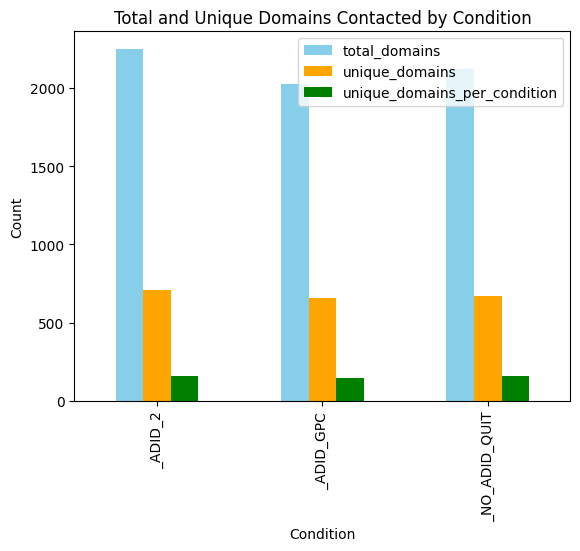

In [8]:
# Calculate unique domains for each condition
unique_domains_adid_2_count = len(unique_domains_adid_2)
unique_domains_adid_gpc_count = len(unique_domains_adid_gpc)
unique_domains_no_adid_quit_count = len(unique_domains_no_adid_quit)

print(f"Unique domains in _ADID_2: {unique_domains_adid_2_count}")
print(f"Unique domains in _ADID_GPC: {unique_domains_adid_gpc_count}")
print(f"Unique domains in _NO_ADID_QUIT: {unique_domains_no_adid_quit_count}")

# 2. Domain counts by condition
condition_summary = domain_df.groupby('condition').agg({
    'total_domains': 'sum',
    'unique_domains': 'sum'
}).reset_index()

# Add the unique domain counts to the summary for each condition
condition_summary['unique_domains_per_condition'] = [
    unique_domains_adid_2_count,
    unique_domains_adid_gpc_count,
    unique_domains_no_adid_quit_count
]

print(condition_summary)

plt.figure(figsize=(10, 6))
condition_summary.plot(kind='bar', x='condition', y=['total_domains', 'unique_domains', 'unique_domains_per_condition'], color=['skyblue', 'orange', 'green'])
plt.title('Total and Unique Domains Contacted by Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()


Unique Domains Contacted Under Each Condition:
                                   _ADID_2  \
0                      us1tr.tutotoons.com   
1    rr5---sn-jvhj5nu-cvnr.googlevideo.com   
2                      apps2.tutotoons.com   
3                      kidremote.b-cdn.net   
4                        beacons4.gvt2.com   
5   rr8---sn-jvhj5nu-cvnee.googlevideo.com   
6                           assets.soom.la   
7       cryptauthenrollment.googleapis.com   
8      android-context-data.googleapis.com   
9       proactivebackend-pa.googleapis.com   
10    rr1---sn-bvvbax-cvne.googlevideo.com   
11   rr5---sn-jvhj5nu-cvnd.googlevideo.com   
12                 quake-pa.googleapis.com   
13                       config.inmobi.com   
14                                           
15                                           
16                                           
17                                           

                                _ADID_GPC  \
0               1-172-11260-4.b.c

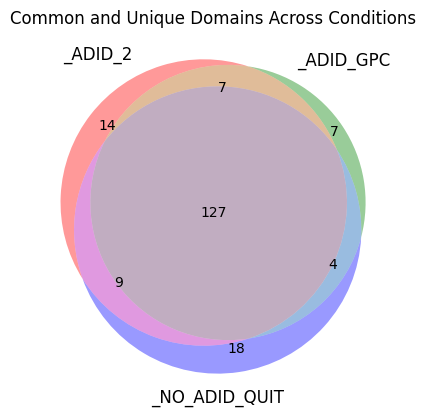

In [9]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import pandas as pd

# Analyze common and unique domains across conditions
domains_adid_2 = set(domain_df[domain_df['condition'] == '_ADID_2']['domains'].apply(eval).sum())
domains_adid_gpc = set(domain_df[domain_df['condition'] == '_ADID_GPC']['domains'].apply(eval).sum())
domains_no_adid_quit = set(domain_df[domain_df['condition'] == '_NO_ADID_QUIT']['domains'].apply(eval).sum())

# Print domains only contacted under each specific condition
unique_adid_2 = domains_adid_2 - domains_adid_gpc - domains_no_adid_quit
unique_adid_gpc = domains_adid_gpc - domains_adid_2 - domains_no_adid_quit
unique_no_adid_quit = domains_no_adid_quit - domains_adid_2 - domains_adid_gpc

# Find the maximum length of the unique domain lists
max_length = max(len(unique_adid_2), len(unique_adid_gpc), len(unique_no_adid_quit))

# Pad the lists to ensure they have the same length
padded_adid_2 = list(unique_adid_2) + [''] * (max_length - len(unique_adid_2))
padded_adid_gpc = list(unique_adid_gpc) + [''] * (max_length - len(unique_adid_gpc))
padded_no_adid_quit = list(unique_no_adid_quit) + [''] * (max_length - len(unique_no_adid_quit))

# Create a DataFrame to organize the unique domains into a table format
unique_domains_df = pd.DataFrame({
    '_ADID_2': padded_adid_2,
    '_ADID_GPC': padded_adid_gpc,
    '_NO_ADID_QUIT': padded_no_adid_quit
})

# Print the DataFrame
print("Unique Domains Contacted Under Each Condition:")
print(unique_domains_df)

# Generate the Venn diagram
venn3([domains_adid_2, domains_adid_gpc, domains_no_adid_quit],
      set_labels=('_ADID_2', '_ADID_GPC', '_NO_ADID_QUIT'))

plt.title('Common and Unique Domains Across Conditions')
plt.show()

# Save the unique domains to a CSV file
unique_domains_df.to_csv('/content/drive/MyDrive/GAME_EDUCATIONAL/unique_domains_per_condition.csv', index=False)

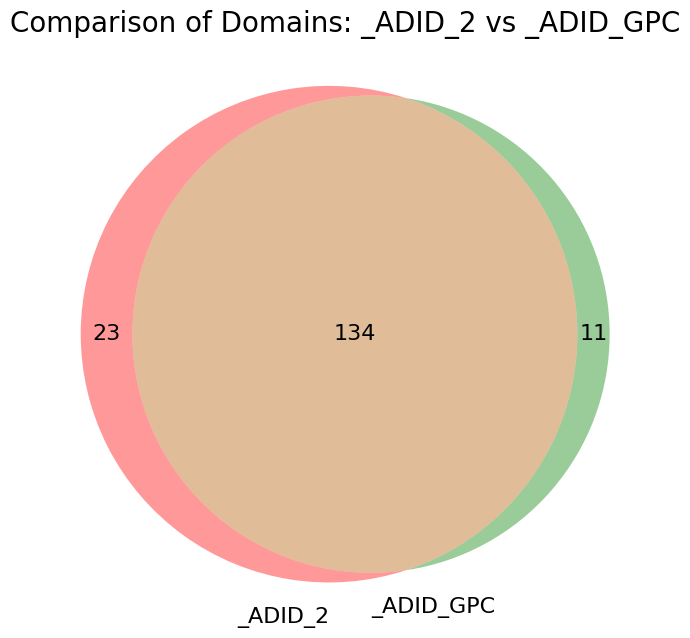

Domains uniquely contacted under the _ADID_2 condition (23): {'us1tr.tutotoons.com', 'rr5---sn-jvhj5nu-cvnr.googlevideo.com', 'cdn-creatives-akamaistls-prd.acquire.unity3dusercontent.com', 'rr8---sn-jvhj5nu-cvnee.googlevideo.com', 'cryptauthenrollment.googleapis.com', 'cdn-store-icons-akamai-prd.unityads.unity3d.com', 'apps2.tutotoons.com', 'kidremote.b-cdn.net', 'play-lh.googleusercontent.com', 'rr1---sn-bvvbax-cvne.googlevideo.com', 'rr5---sn-jvhj5nu-cvnd.googlevideo.com', 'v.ssacdn.com', 'beacons4.gvt2.com', 'geller-pa.googleapis.com', 'assets.soom.la', 'www.googleapis.com', 'quake-pa.googleapis.com', 'play.googleapis.com', 'telemetry.sdk.inmobi.com', 'sdk-diagnostics.prd.mz.internal.unity3d.com', 'android-context-data.googleapis.com', 'proactivebackend-pa.googleapis.com', 'config.inmobi.com'}
Domains uniquely contacted under the _ADID_GPC condition (11): {'1-72-11260-4.b.cdn13.com', '1-172-11260-4.b.cdn13.com', 'crashlyticsreports-pa.googleapis.com', '1-196-11260-4.b.cdn13.com', 'r

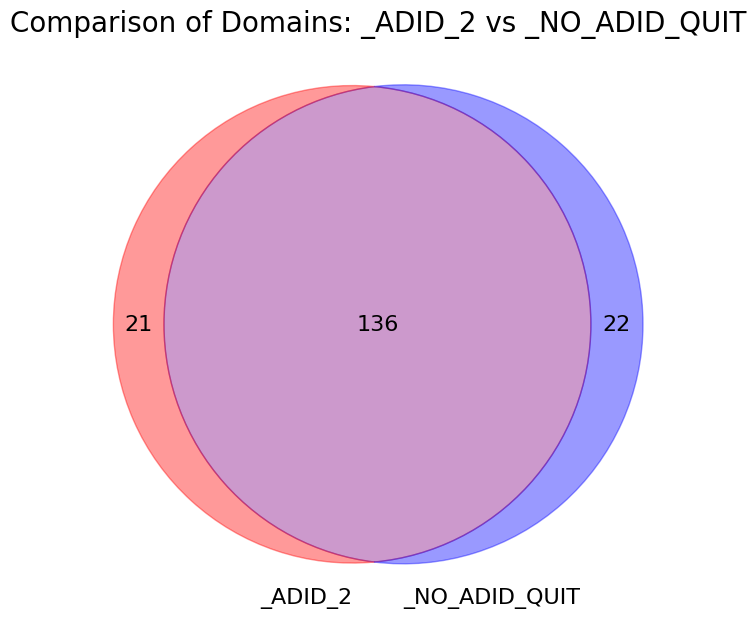

Domains uniquely contacted under the _ADID_2 condition (21): {'us1tr.tutotoons.com', 'rr5---sn-jvhj5nu-cvnr.googlevideo.com', 'encrypted-tbn1.gstatic.com', 'rr8---sn-jvhj5nu-cvnee.googlevideo.com', 'cryptauthenrollment.googleapis.com', 'encrypted-tbn0.gstatic.com', 'httpkafka.unityads.unity3d.com', 'assets.lunalabs.io', 'beacons.gcp.gvt2.com', 'kidremote.b-cdn.net', 'apps2.tutotoons.com', 'encrypted-tbn3.gstatic.com', 'rr1---sn-bvvbax-cvne.googlevideo.com', 'rr5---sn-jvhj5nu-cvnd.googlevideo.com', '1-76-11260-4.b.cdn13.com', 'beacons4.gvt2.com', 'assets.soom.la', 'quake-pa.googleapis.com', 'android-context-data.googleapis.com', 'proactivebackend-pa.googleapis.com', 'config.inmobi.com'}
Domains uniquely contacted under the _NO_ADID_QUIT condition (22): {'rr2---sn-jvhj5nu-cvne7.googlevideo.com', 'tr-us.adsmoloco.com', 'deviceintegritytokens-pa.googleapis.com', 'i.l.inmobicdn.net', 'rr3---sn-jvhj5nu-cvne7.googlevideo.com', 'userlocation.googleapis.com', 'agnss.goog', 'platform.ssacdn.com'

In [11]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import pandas as pd

# Load the domain analysis results from the CSV file
domain_df = pd.read_csv('/content/drive/MyDrive/GAME_EDUCATIONAL/domain_results.csv')

# Analyze common and unique domains across conditions
domains_adid_2 = set(domain_df[domain_df['condition'] == '_ADID_2']['domains'].apply(eval).sum())
domains_adid_gpc = set(domain_df[domain_df['condition'] == '_ADID_GPC']['domains'].apply(eval).sum())
domains_no_adid_quit = set(domain_df[domain_df['condition'] == '_NO_ADID_QUIT']['domains'].apply(eval).sum())

# Function to plot Venn diagrams with larger font size and custom colors
def plot_venn2(subset1, subset2, labels, title, colors=None):
    plt.figure(figsize=(8, 8))
    venn = venn2([subset1, subset2], set_labels=labels)

    for text in venn.set_labels:
        text.set_fontsize(16)
    for text in venn.subset_labels:
        text.set_fontsize(16)

    if colors:
        venn.get_patch_by_id('10').set_color(colors[0])  # Color for subset1 only
        venn.get_patch_by_id('01').set_color(colors[1])  # Color for subset2 only
        venn.get_patch_by_id('11').set_color(colors[2])  # Color for intersection

    plt.title(title, fontsize=20)
    plt.show()

    # Print unique domains for each subset
    unique_1 = subset1 - subset2
    unique_2 = subset2 - subset1
    print(f"Domains uniquely contacted under the {labels[0]} condition ({len(unique_1)}): {unique_1}")
    print(f"Domains uniquely contacted under the {labels[1]} condition ({len(unique_2)}): {unique_2}")

# Create pairwise Venn diagrams

# _ADID_2 vs _ADID_GPC
plot_venn2(domains_adid_2, domains_adid_gpc, ('_ADID_2', '_ADID_GPC'), 'Comparison of Domains: _ADID_2 vs _ADID_GPC')

# _ADID_2 vs _NO_ADID_QUIT with custom color for _NO_ADID_QUIT
plot_venn2(domains_adid_2, domains_no_adid_quit, ('_ADID_2', '_NO_ADID_QUIT'), 'Comparison of Domains: _ADID_2 vs _NO_ADID_QUIT', colors=['red', 'blue', 'purple'])